### Notebook to analyze the data from the diluted standard
Figure 2 & 3

In [1]:
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import silhouette_samples
import seaborn as sns
import sceptre as spt

In [2]:
# create result folder
res_dir = '../results/diluted_sample/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [3]:
# load PD tables
prot = {'MS2': pd.read_table('../data/diluted_sample/200x/MS2_Proteins.txt'),
        'MS3': pd.read_table('../data/diluted_sample/200x/MS3_Proteins.txt'),
        'reticle': pd.read_table('../data/diluted_sample/200x/RETICLE_Proteins.txt')}
psms = {'MS2': pd.read_table('../data/diluted_sample/200x/MS2_PSMs.txt'),
        'MS3': pd.read_table('../data/diluted_sample/200x/MS3_PSMs.txt'),
        'reticle': pd.read_table('../data/diluted_sample/200x/RETICLE_PSMs.txt')}
msms = {'MS2': pd.read_table('../data/diluted_sample/200x/MS2_MSMSSpectrumInfo.txt'),
        'MS3': pd.read_table('../data/diluted_sample/200x/MS3_MSMSSpectrumInfo.txt'),
        'reticle': pd.read_table('../data/diluted_sample/200x/RETICLE_MSMSSpectrumInfo.txt')}
quan = {'MS2': pd.read_table('../data/diluted_sample/200x/MS2_QuanSpectra.txt'),
        'MS3': pd.read_table('../data/diluted_sample/200x/MS3_QuanSpectra.txt'),
        'reticle': pd.read_table('../data/diluted_sample/200x/RETICLE_QuanSpectra.txt')}
files = {'MS2': pd.read_table('../data/diluted_sample/200x/MS2_InputFiles.txt'),
        'MS3': pd.read_table('../data/diluted_sample/200x/MS3_InputFiles.txt'),
        'reticle': pd.read_table('../data/diluted_sample/200x/RETICLE_InputFiles.txt')}

In [4]:
# mark and remove potential contaminants
contaminants = pd.read_table('../data/contaminants.txt')['Accession']
for p in prot.keys():
    prot[p]['contaminant'] = prot[p]['Accession'].isin(contaminants)
    prot[p] = prot[p][prot[p]['contaminant']==False]

In [5]:
# map methods and their replicates
mapping = pd.read_csv('../data/diluted_sample/200x/mapping.csv')
mapping['Method'] = mapping[['method', 'quant it']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
cells = {'126': 'booster',
        '127N': 'BLAST1',
        '127C': 'empty',
        '128N': 'LSC1',
        '128C': 'empty',
        '129N': 'PROG1',
        '129C': 'empty',
        '130N': 'empty',
        '130C': 'LSC2',
        '131N': 'BLAST2',
        '131C': 'PROG2',
        '132N': 'empty',
        '132C': 'BLAST3',
        '133N': 'PROG3',
        '133C': 'LSC3',
        '134N': 'empty'}

for p in psms.keys():
    psms[p] = psms[p].merge(mapping.set_index('file')['Method'], left_on='Spectrum File', right_index=True)
    msms[p] = msms[p].merge(mapping.set_index('file')['Method'], left_on='Spectrum File', right_index=True)
    quan[p] = quan[p].merge(mapping.set_index('file')['Method'], left_on='Spectrum File', right_index=True)

In [6]:
# load into scanpy
adata = {}
for p in prot.keys():
    cols = list(map(lambda x: x.split(' '), prot[p].columns[prot[p].columns.str.contains('Abundance')]))
    file_id = [x[-2] for x in cols]
    channel = [x[-1] for x in cols]
    method = [psms[p][['File ID', 'Method']].drop_duplicates().set_index('File ID').loc[f, 'Method'] for f in file_id]
    cell = [cells[x] for x in channel]
    celltype = [x[:-1] for x in cell]
    quant = prot[p].set_index('Accession').copy()
    quant = quant[quant.columns[quant.columns.str.contains('Abundance')]]
    quant.columns = pd.MultiIndex.from_tuples(zip(file_id, channel, method, cell, celltype), names=['File ID', 'Channel', 'Method', 'Cell Pool', 'Celltype'])
    quant = quant.loc[:, (~quant.columns.get_level_values(3).str.contains('empty|booster'))] # remove empty channels
    quant = quant.loc[:, (~quant.columns.get_level_values(3).str.contains('1'))] # remove the first cells due to contamination from the booster
    quant[quant < 1.1] = pd.NA # set S/N values below 1.1 to NA
    quant = quant.dropna(how='all').fillna(0) # remove all NA proteins and fill remaining NA with 0
    # save to file and load it in scanpy
    quant.to_csv('../results/tmp/scanpy_data.txt', sep='\t', header=False, index=True)
    adata[p] = sc.read_text('../results/tmp/scanpy_data.txt', delimiter='\t', first_column_names=False).T
    adata[p].obs = quant.columns.to_frame(index=False)
    adata[p].obs.index = adata[p].obs.index.astype(str)

In [7]:
# merge adatas
adata = sc.AnnData.concatenate(*adata.values(), join='outer', batch_key='PD', batch_categories=adata.keys(), fill_value=0)

In [8]:
# apply file normalization to the files of each of the method.
# file normalization equalizes the median value of each protein across files.
for j in adata.obs['Method'].unique():
    adata_slice = adata[adata.obs['Method']==j].copy()
    spt.normalize(adata_slice, method='file', drop_na=False)
    adata.X[adata.obs['Method']==j] = adata_slice.X

0 values below 1.1 were set to 0
1 values below 1.1 were set to 0
5 values below 1.1 were set to 0
1 values below 1.1 were set to 0
5 values below 1.1 were set to 0
1 values below 1.1 were set to 0


In [9]:
# calculate basic stats for each method

ms_stats = []
for m in ['MS2', 'MS3', 'reticle']:
    for it in ['500', '750']:
        fs = quan[m][quan[m]['Method']==f"{m}_{it}"]['File ID'].unique()
        for f in fs:
            quan_spectra = len(quan[m][(quan[m]['Method']==f"{m}_{it}") & (quan[m]['File ID']==f)])
            identified_quan_spectra = len(quan[m][(quan[m]['Method']==f"{m}_{it}") & (quan[m]['File ID']==f) & (quan[m]['Number of PSMs']>0)])
            PSM_rate_quan_spectra = identified_quan_spectra / quan_spectra
            peptides = len(psms[m][(psms[m]['Method']==f"{m}_{it}") & (psms[m]['File ID']==f)]['Annotated Sequence'].unique())
            proteins = len(psms[m][(psms[m]['Method']==f"{m}_{it}") & (psms[m]['File ID']==f)]['Master Protein Accessions'].unique())
            
            adata_slice = adata[(adata.obs['Method']==f"{m}_{it}") & (adata.obs['File ID']==f)].copy()
            sc.pp.filter_genes(adata_slice, min_cells=1)
            avg_IDs = (~pd.DataFrame(adata_slice.X).replace(0, np.nan).isna()).sum(axis=1).mean().round().astype(int)
                        
            ms_stats.append({'method': f"{m} {it}ms", 'quan_spectra': quan_spectra, 'identified_quan_spectra': identified_quan_spectra,
                             'PSM_rate_quan_spectra': PSM_rate_quan_spectra, 'avg_IDs': avg_IDs})

ms_stats = pd.DataFrame(ms_stats)
ms_stats['method'] = ms_stats['method'].replace({'MS3 500ms': 'RTS-MS3 500ms', 'MS3 750ms': 'RTS-MS3 750ms', 'reticle 500ms': 'RETICLE 500ms', 'reticle 750ms': 'RETICLE 750ms'})

filtered out 1024 genes that are detected in less than 1 cells
filtered out 1023 genes that are detected in less than 1 cells
filtered out 1028 genes that are detected in less than 1 cells
filtered out 1222 genes that are detected in less than 1 cells
filtered out 1223 genes that are detected in less than 1 cells
filtered out 1214 genes that are detected in less than 1 cells
filtered out 979 genes that are detected in less than 1 cells
filtered out 952 genes that are detected in less than 1 cells
filtered out 965 genes that are detected in less than 1 cells
filtered out 1089 genes that are detected in less than 1 cells
filtered out 1089 genes that are detected in less than 1 cells
filtered out 1068 genes that are detected in less than 1 cells
filtered out 706 genes that are detected in less than 1 cells
filtered out 712 genes that are detected in less than 1 cells
filtered out 705 genes that are detected in less than 1 cells
filtered out 878 genes that are detected in less than 1 cells

In [10]:
ms_stats

,method,quan_spectra,identified_quan_spectra,PSM_rate_quan_spectra,avg_IDs
0,MS2 500ms,8976,3796,0.422906,841
1,MS2 500ms,8997,3761,0.418028,849
2,MS2 500ms,8921,3673,0.411725,837
3,MS2 750ms,6269,2659,0.424151,682
4,MS2 750ms,6211,2637,0.424569,691
5,MS2 750ms,6277,2654,0.422813,696
6,RTS-MS3 500ms,5321,2997,0.563240,866
7,RTS-MS3 500ms,5274,3032,0.574896,883
8,RTS-MS3 500ms,5212,2972,0.570223,887
9,RTS-MS3 750ms,4085,2467,0.603917,784


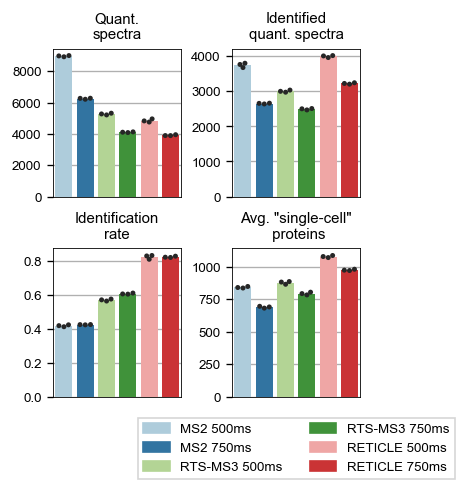

In [11]:
# plot the stats

fig, axs = plt.subplots(2, 2, figsize=(3.3, 5), gridspec_kw={'wspace':0.4, 'hspace':0.35})
axs = axs.flatten()
s = 3

sns.barplot(data=ms_stats, x='method', y='quan_spectra', ax=axs[0], ci=None, palette='Paired')
sns.swarmplot(data=ms_stats, x='method', y='quan_spectra', ax=axs[0], color=".15", size=s)
axs[0].title.set_text('Quant.\nspectra')

sns.barplot(data=ms_stats, x='method', y='identified_quan_spectra', ax=axs[1], ci=None, palette='Paired')
sns.swarmplot(data=ms_stats, x='method', y='identified_quan_spectra', ax=axs[1], color=".15", size=s)
axs[1].title.set_text('Identified\nquant. spectra')

sns.barplot(data=ms_stats, x='method', y='PSM_rate_quan_spectra', ax=axs[2], ci=None, palette='Paired')
sns.swarmplot(data=ms_stats, x='method', y='PSM_rate_quan_spectra', ax=axs[2], color=".15", size=s)
axs[2].title.set_text('Identification\nrate')

p = sns.barplot(data=ms_stats, x='method', y='avg_IDs', ax=axs[3], ci=None, palette='Paired')
sns.swarmplot(data=ms_stats, x='method', y='avg_IDs', ax=axs[3], color=".15", size=s)
axs[3].title.set_text('Avg. "single-cell"\n proteins')

patches = [matplotlib.patches.Patch(color=sns.color_palette(palette='Paired', desat=0.75)[i], label=t) for i,t in enumerate(t.get_text() for t in p.get_xticklabels())]

for ax in axs:
    ax.grid(axis='y')
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)

fig.subplots_adjust(bottom=0.3, wspace=0.33)

axs[3].legend(handles = patches , loc='upper center', 
             bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=2)

plt.savefig(res_dir + 'ms_stats.pdf', transparent=True, bbox_inches='tight')

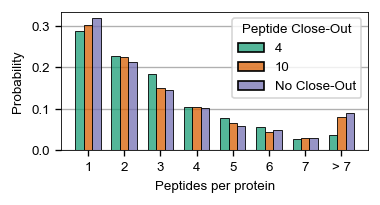

In [12]:
# investigate closeout

psms_closeout = pd.read_table('../data/diluted_sample/100x/RETICLE_closeout_PSMs.txt')
sic = ['Abundance 130C', 'Abundance 131N', 'Abundance 131C', 'Abundance 132C', 'Abundance 133N', 'Abundance 133C']
# only with single-cell signal
psms_closeout = psms_closeout[(psms_closeout[sic] > 1.1).any(axis=1)]
df = psms_closeout.groupby(['Spectrum File', 'Master Protein Accessions'])['Annotated Sequence'].unique().apply(len).to_frame().reset_index()
# only overlapping proteins
ps = df.groupby('Spectrum File')['Master Protein Accessions'].unique()
intersec = [p for p in ps[0] if (p in ps[1]) and (p in ps[2])]
df = df[df['Master Protein Accessions'].isin(intersec)]
# set max bin
df.loc[df['Annotated Sequence']>=8, 'Annotated Sequence'] = 8
df['Spectrum File'] = df['Spectrum File'].replace({'20210408_HB_BF_U3000_uPAC_50cm_precol_114min_TMTpro2_150nlmin_2CV_scMS_RETICLE_turbo23ms_500ms_100c_2_20210410025807.raw': '4',
                                                   '20210408_HB_BF_U3000_uPAC_50cm_precol_114min_TMTpro2_150nlmin_2CV_scMS_RETICLE_turbo23ms_500ms_100c_nocloseout.raw': 'No Close-Out',
                                                   '20210408_HB_BF_U3000_uPAC_50cm_precol_114min_TMTpro2_150nlmin_2CV_scMS_RETICLE_turbo23ms_500ms_100c_maxpep10.raw': '10'})
df.columns = ['Peptide Close-Out', 'Master Protein Accessions', 'Peptides per protein']

fig, ax = plt.subplots(figsize=(3.3, 1.5))
sns.histplot(data=df, x='Peptides per protein', hue='Peptide Close-Out', ax=ax, multiple="dodge", stat="probability", discrete=True, common_norm=False, shrink=.7, palette='Dark2')
ax.grid(axis='y')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '> 7'])
plt.savefig(res_dir + 'closeout.pdf', transparent=True, bbox_inches='tight')

In [13]:
method_dict = {'MS2_500': 'MS2 500ms', 'MS2_750': 'MS2 750ms',
               'MS3_500': 'RTS-MS3 500ms', 'MS3_750': 'RTS-MS3 750ms',
               'reticle_500': 'RETICLE 500ms', 'reticle_750': 'RETICLE 750ms'}

In [14]:
adata.obs

,File ID,Channel,Method,Cell Pool,Celltype,PD
0-MS2,F1,130C,MS2_500,LSC2,LSC,MS2
1-MS2,F1,131N,MS2_500,BLAST2,BLAST,MS2
2-MS2,F1,131C,MS2_500,PROG2,PROG,MS2
3-MS2,F1,132C,MS2_500,BLAST3,BLAST,MS2
4-MS2,F1,133N,MS2_500,PROG3,PROG,MS2
...,...,...,...,...,...,...
31-reticle,F6,131N,reticle_750,BLAST2,BLAST,reticle
32-reticle,F6,131C,reticle_750,PROG2,PROG,reticle
33-reticle,F6,132C,reticle_750,BLAST3,BLAST,reticle
34-reticle,F6,133N,reticle_750,PROG3,PROG,reticle


In [15]:
# compare fold changes to library for BLAST and LSC including pvalues

ms3_lib = pd.read_table('../data/library_MS3_Proteins.txt')
par = {}
fcs = {}
tps = {}

for m in adata.obs['Method'].unique():
    adata_slice = adata[(adata.obs['Method']==m)].copy()
    sc.pp.normalize_total(adata_slice, exclude_highly_expressed=True) # median shift of total intensity across cells
    sc.pp.log1p(adata_slice, base=2) # log2(x+1) transformation
    # de test
    spt.de_test(adata_slice, by='Celltype', group1='LSC', group2='BLAST', use_raw=False)
    res = adata_slice.uns['de_test']['results']
    res = res.merge(ms3_lib[['Accession',
                         'Abundance Ratio log2 LSC  BLAST',
                         'Abundance Ratio Adj P-Value LSC  BLAST']].rename(columns={
        'Abundance Ratio log2 LSC  BLAST':'log2foldchange_lib',
        'Abundance Ratio Adj P-Value LSC  BLAST': 'pval_adj_lib'
    }), left_on='gene', right_on='Accession')
    res = res.dropna()
    
    testable = len(res)
    tps[m] = res[(res['pval'] <= 0.05) & (res['pval_adj_lib'] <= 0.05) & ((res['log2foldchange']*res['log2foldchange_lib'])>= 0)]['gene']
    TP = len(tps[m])
    FP = len(res[((res['pval'] <= 0.05) & (res['pval_adj_lib'] <= 0.05) & ((res['log2foldchange']*res['log2foldchange_lib'])< 0)) | ((res['pval'] <= 0.05) & (res['pval_adj_lib'] > 0.05))])
    TN = len(res[(res['pval'] > 0.05) & (res['pval_adj_lib'] > 0.05)])
    FN = len(res[(res['pval'] > 0.05) & (res['pval_adj_lib'] <= 0.05)])
    FDR = FP / (TP + FP)
    sensitivity = TP / (TP + FN)
    specificity = FP / (TN + FP)
    par[m] = [testable, TP, FP, TN, FN, FDR, sensitivity, specificity]
    
    means = pd.DataFrame({'gene': adata_slice.var_names, 'mean': np.mean(adata_slice.X, axis=0)})
    res = res.merge(means, on='gene', how='left')
    res['ratio_fc'] = res['log2foldchange'] / res['log2foldchange_lib']
    res['error_fc'] = abs(res['log2foldchange'] - res['log2foldchange_lib'])
    fcs[m] = res.copy()

de_stats = pd.DataFrame(par, index=['Testable', 'TP', 'FP', 'TN', 'FN', 'FDR', 'Sensitivity', 'Specificity']).T
de_stats = de_stats.round(2)

all_means = pd.concat([x[['gene', 'mean']] for x in fcs.values()]).groupby('gene').mean()

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during nor

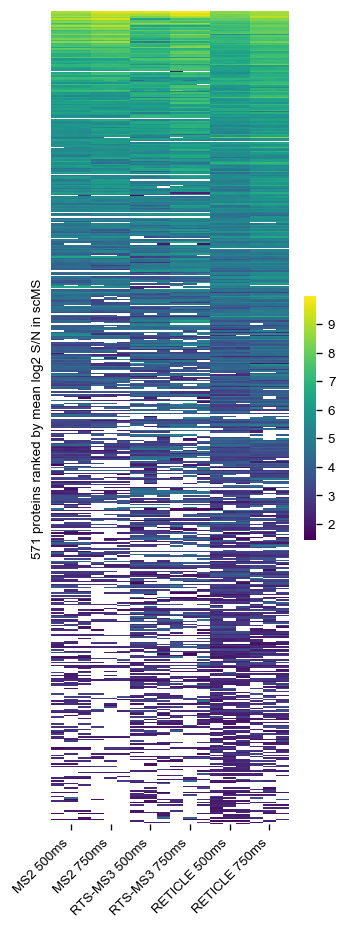

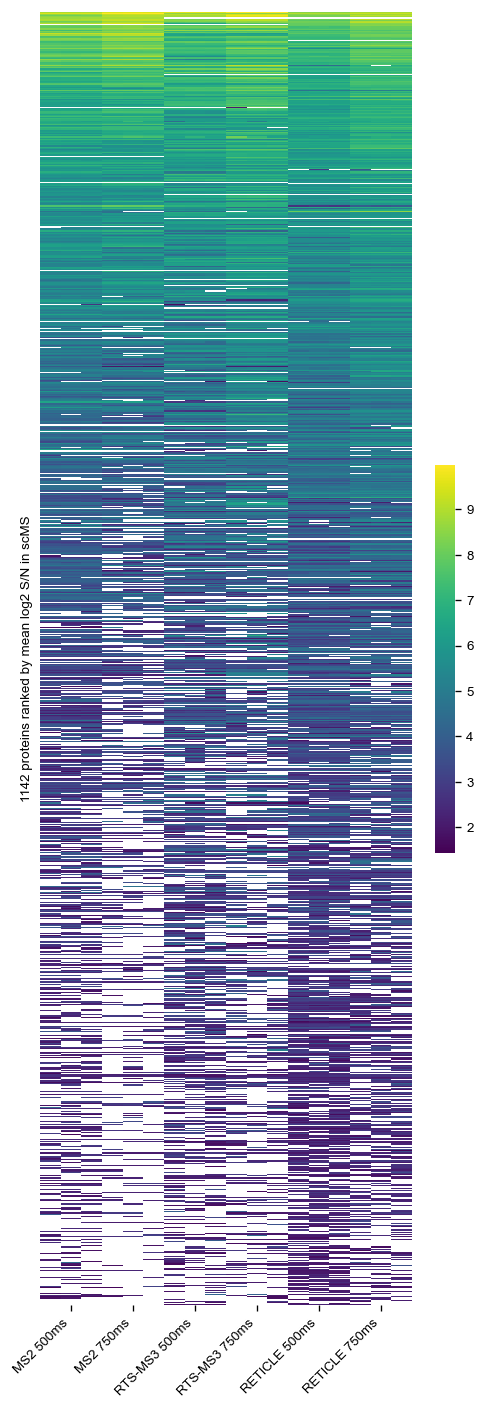

In [16]:
# expression matrix sorted by S/N

sorted_prot = pd.DataFrame(index=pd.DataFrame(ms3_lib[ms3_lib.columns[ms3_lib.columns.str.contains('Abundances Normalized')]].median(axis=1).values, index=ms3_lib['Accession']).dropna().sort_values(0, ascending=False).index)
sorted_prot = pd.DataFrame(index=all_means.sort_values('mean', ascending=False).index)

for m in adata.obs['Method'].unique():
    fs = adata[(adata.obs['Method']==m)].obs['File ID'].unique()
    for i, f in enumerate(fs):
        adata_slice = adata[(adata.obs['Method']==m) & (adata.obs['File ID']==f)].copy()
        sc.pp.normalize_total(adata_slice, exclude_highly_expressed=True) # median shift of total intensity across cells
        sc.pp.log1p(adata_slice, base=2) # log2(x+1) transformation
        df = pd.DataFrame(pd.DataFrame(adata_slice.X.T).replace(0, np.nan).mean(axis=1).values, index=adata_slice.var_names)
        df.columns = [m+f]
        if i == 1:
            df.columns = [m]
        sorted_prot = sorted_prot.merge(df, left_index=True, right_index=True, how='left')

sorted_prot = sorted_prot.dropna(axis=0, how='all')
downsampled_sorted_prot = sorted_prot.iloc[::2]

fig, ax = plt.subplots(figsize=(3.2, 8.8))
sns.heatmap(downsampled_sorted_prot, ax=ax, cmap='viridis', xticklabels=True, yticklabels=False, cbar_kws={"shrink": .3})
ax.set_xticks(ax.get_xticks()[[1, 4, 7, 10, 13, 16]])
ax.set_xticklabels(method_dict.values(), rotation=45, ha='right')
ax.set_ylabel(f'{len(downsampled_sorted_prot)} proteins ranked by mean log2 S/N in scMS')
ax.set_facecolor('white')
plt.savefig(res_dir + 'ordered_heatmap_downsampled.pdf', transparent=True, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5, 14))
sns.heatmap(sorted_prot, ax=ax, cmap='viridis', xticklabels=True, yticklabels=False, cbar_kws={"shrink": .3})
ax.set_xticks(ax.get_xticks()[[1, 4, 7, 10, 13, 16]])
ax.set_xticklabels(method_dict.values(), rotation=45, ha='right')
ax.set_ylabel(f'{len(sorted_prot)} proteins ranked by mean log2 S/N in scMS')
ax.set_facecolor('white')
plt.savefig(res_dir + 'ordered_heatmap.pdf', transparent=True, bbox_inches='tight')

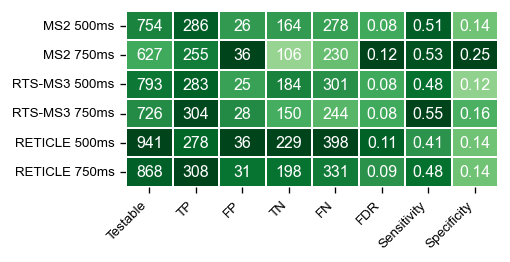

In [17]:
# DE-analysis

de_stats.iloc[:, :4] = de_stats.iloc[:, :4].astype(int)
scaled_df = de_stats/(de_stats.max(axis=0)) # scale for colormap
scaled_df.index = list(method_dict.values())
fig, ax = plt.subplots(figsize=(4, 1.9))
sns.heatmap(scaled_df, annot=de_stats, linewidths=1, fmt='g', cmap="Greens", cbar=False, ax=ax, vmin=0.1, vmax=1, annot_kws={'color':'white', 'size':'large'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig(res_dir + 'DE_analysis.pdf', transparent=True, bbox_inches='tight')

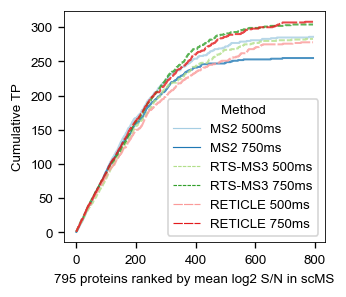

In [18]:
# cumulative distribution of TPs sorted by S/N

# testable proteins in scMS that are positiv hits in libray
pos_lib = ms3_lib[ms3_lib['Abundance Ratio Adj P-Value LSC  BLAST']<= 0.05]['Accession']
all_testable = pd.concat([x['gene'] for x in fcs.values()]).unique()
de_prots = pd.DataFrame(index=pos_lib[pos_lib.isin(all_testable)])
de_prots = de_prots.merge(all_means, right_index=True, left_index=True)
for m in adata.obs['Method'].unique():
    de_prots[m] = de_prots.index.isin(tps[m])
de_prots = de_prots.sort_values('mean', ascending=False)
de_prots['mean'] = [i for i in range(len(de_prots))]
de_prots = de_prots.reset_index().set_index(['index', 'mean']).apply(np.cumsum).reset_index().melt(id_vars=['index', 'mean'])
de_prots.columns = ['gene', 'rank', 'Method', 'cumsum']
de_prots['Method'] = de_prots['Method'].map(method_dict)

fig, ax = plt.subplots(figsize=(2.8, 2.5))
sns.lineplot(data=de_prots, x='rank', y='cumsum', hue='Method', palette='Paired', style='Method', dashes=['', '', (3,1), (3,1), (8,1), (8,1)], linewidth=1.2, alpha=0.8, ax=ax)
ax.set_ylabel('Cumulative TP')
ax.set_xlabel(f"{len(de_prots['gene'].unique())} proteins ranked by mean log2 S/N in scMS")
plt.savefig(res_dir + 'cumsum_TP.pdf', transparent=True, bbox_inches='tight')

                value
variable             
MS2_500      0.799449
MS2_750      0.773112
MS3_500      0.978804
MS3_750      0.943814
reticle_500  0.853058
reticle_750  0.791166


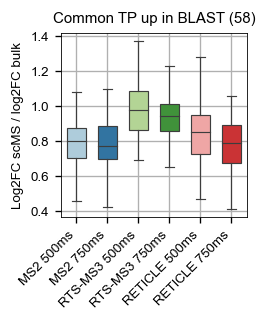

In [19]:
# comparison of ratios of log2FCs in scMS and bulk from TPs that are down in LSC

fc_ratios = {}
tps_overlap = set.intersection(*map(set,tps.values()))
common_tp_down = ms3_lib[(ms3_lib['Accession'].isin(tps_overlap)) & (ms3_lib['Abundance Ratio log2 LSC  BLAST']<0)]['Accession']
for m in adata.obs['Method'].unique():
    fc_ratios[m] = fcs[m][fcs[m]['gene'].isin(common_tp_down)]['ratio_fc']
fc_ratios = pd.DataFrame(fc_ratios).melt().dropna()
fc_ratios['value'] = fc_ratios['value'].astype(float)

fig, ax = plt.subplots(figsize=(2, 2))
sns.boxplot(data=fc_ratios, x='variable', y='value', ax=ax, showfliers=False, dodge=False, width=0.6, palette='Paired')
ax.set_title('Common TP up in BLAST ({})'.format(len(common_tp_down)))
ax.axes.get_xaxis().get_label().set_visible(False)
ax.set_xticklabels(list(method_dict.values()), rotation=45, ha='right')
ax.grid()
plt.ylabel('Log2FC scMS / log2FC bulk')
print(fc_ratios.groupby('variable').median())
plt.savefig(res_dir + 'ratio_compression.pdf', transparent=True, bbox_inches='tight')

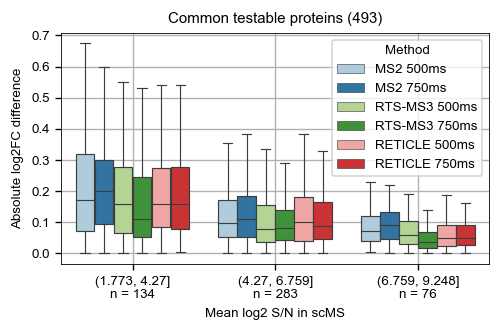

In [20]:
# absolute log2FC difference scMS and bulk of common proteins

all_overlap = set.intersection(*map(set,[x['gene'] for x in fcs.values()]))
all_means = pd.concat([x[['gene', 'mean']] for x in fcs.values()]).groupby('gene').mean()
fc_error = pd.DataFrame(all_overlap)
fc_error.columns = ['gene']
fc_error = fc_error.merge(all_means, on='gene')
fc_error['int_bin'] = pd.cut(fc_error['mean'], 3)
n = fc_error.groupby('int_bin').size()
fc_error = fc_error.drop('mean', axis=1)
for m in adata.obs['Method'].unique():
    fc_error = fc_error.merge(fcs[m][['gene', 'error_fc']].rename(columns={'error_fc': m}), left_on='gene', right_on='gene')
fc_error = fc_error.melt(id_vars=['gene', 'int_bin'])
fc_error['value'] = fc_error['value'].astype(float)
fc_error.columns = ['gene', 'Mean log2 S/N in scMS', 'Method', 'Absolute log2FC difference']
fc_error['Method'] = fc_error['Method'].map(method_dict)

fig, ax = plt.subplots(figsize=(4.6, 2.5))
sns.boxplot(data=fc_error ,y='Absolute log2FC difference', x='Mean log2 S/N in scMS', hue='Method', showfliers=False, palette="Paired", ax=ax)
ax.set_title('Common testable proteins ({})'.format(len(all_overlap)))
x_ticks = n.reset_index().apply(lambda x: '\nn = '.join(x.astype(str)), axis=1).values
ax.set_xticklabels(x_ticks)
ax.grid()
plt.savefig(res_dir + 'accuracy.pdf', transparent=True, bbox_inches='tight')

In [22]:
os.system('jupyter nbconvert --to html diluted_sample.ipynb --output-dir={}'.format(res_dir))

[NbConvertApp] Converting notebook diluted_sample.ipynb to html
[NbConvertApp] Writing 1183545 bytes to ../results/diluted_sample/diluted_sample.html


0